In [1]:
from __future__ import division
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import norm

# Week 7

This weeks takes a first look at the pricing of derivatives using Monte Carlo methods. An example of a derivative is a European Call Option. This is a contract which gives the holder of the contract the right but not the obligation to purchase the underlying (e.g. a stock or an index) at a set price $K$ (called the strike) at the time of maturity $T$ of the contract. 

At maturity the derivative results in a payoff, which is a general function of the underyling. E.g. for a European Call of a stock the payoff function is the difference of the underlying price and the strike, giving $S(T) - K$. However, you would not exercise the option if the stock price is lower than the strike. Thefore the payoff is given by $\max\big(S(T) - K, 0\big)$.

The question we now ask is: given the payoff of a derivative how do we determine the price of this derivative at an earlier time $t$? For this we have to make some assumptions regarding the statistical model of the underlying.

#### demo_priceEuropeanCallMC and related files

We now consider the Black-Scholes model. The underlying is a stock and this stock is modelled using geometric Brownian motion. The price of the derivative is given by the expectation value of the payoff function, $e^{-rT}\mathbb{E}\big[\textrm{payoff}\big]$, where the averageing is over all possible paths generated from the geometric Brownian motion model. A discount factor $e^{-rT}$ is included to account for the risk premium.

In the Monte Carlo approach we sample over many paths to determine the price of the derivative. The Black-Scholes model has the advantage that it can be solved analytically, so we can compare the MC approach to the exact result. The exact price $C$ of a European Call Option in the Black-Scholes model is given by:

$$C = S_0 \Phi(d_+) - e^{-rT}K\Phi(d_-)$$

where

$$d_{\pm} = \frac{1}{\sigma \sqrt{T}} \log\left(\frac{S_0}{e^{-rT}K}\right) \pm \frac{1}{2}\sigma \sqrt{T}$$

Here $\Phi$ is the CDF of the normal distribution. The remaining parameter are explained in in the python function below.

In [2]:
def priceEuropeanCall(S0, K, r, T, sigma, *args):
    """
    Price of a European call option in the Black-Scholes model
    
    INPUT:
       S0 : Initial value of the underlying asset
        K : Strike 
        r : Risk-free interest rate 
        T : Time to expiry 
    sigma : Volatility 
    *args : extra arguments can be passed, but are not used

    OUTPUT:
    price : Price of the option in the Black-Scholes model  
    """
    
    discountedStrike = np.exp(-r * T) * K
    totalVolatility = sigma * np.sqrt(T)
    
    d_minus = np.log(S0 / discountedStrike) / totalVolatility - .5 * totalVolatility
    d_plus = d_minus + totalVolatility
    
    # The extra zero in the return is the variance in price, which is of course zero. This way the
    # function behaves similar to the Monte Carlo methods defined below which have non-zero variance
    return S0 * norm.cdf(d_plus) - discountedStrike * norm.cdf(d_minus), 0.

For example:

In [3]:
priceEuropeanCall(100, 90, .05, 2., .4)[0]

30.761890179053708

To illustrate the pricing scheme we consider the Call Option price as a function of time to maturity T, while keeping stock price and all other parameters fixed. We consider this for three strike prices: in the money ($S(T) > K$), at the money ($S(T) = K$) and out of the money ($S(T) < K$).

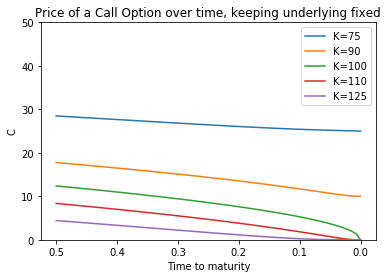

In [8]:
def example(pricingMethod, *args):
    S0 = 100
    K = np.array([75, 90, 100, 110, 125])
    sigma = .4
    r = .05
    # function does not evaluate at T = 0, so we get as close as possible
    T = np.linspace(.5, 1e-15, 75) 
    price = dict((k, np.array([pricingMethod(100, k, .05, t, sigma, *args)[0] for t in T])) for k in K)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    for k in K:
        ax.plot(T, price[k], label='K='+str(k))
    ax.set_xlabel('Time to maturity')
    ax.set_ylabel('C')
    ax.set_title('Price of a Call Option over time, keeping underlying fixed')
    ax.invert_xaxis()
    ax.set_ylim(0, 50)
    plt.legend(loc='best')
    plt.show()

example(priceEuropeanCall)

Note that as the option contract reaches maturity its price starts to converge towards the payoff, $\max(S(T)-K, 0)$. All contracts that are out or at of the money ($K \leq S$ ) become worthless, while the options that are in the money ($K > S$) converge towards the difference $(S(T) - K)$.

Next we implement a Monte Carlo Scheme to evaluate the same price.

In [11]:
def priceEuropeanCallMC(S0,K,r,T,sigma,M):
    """
    Price of a European call option in the Black-Scholes model
    
    INPUT:
       S0 : Initial value of the underlying asset
        K : Strike 
        r : Risk-free interest rate 
        T : Time to expiry 
    sigma : Volatility 
        M : Number of simulations
 

    OUTPUT:
     price_MC : MC estimate of the price of the option in the Black-Scholes model  
     stdev_MC : MC estimate of the standard deviation  
    """  
    
    # generate M samples from N(0,1)
    X = np.random.randn(M)
    
    
    # simulate M trajectories in one step
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * X)
    # define payoff
    payoff = np.where(ST < K, 0, ST - K) # acts as max(ST-K, 0) 
    
    # MC estimate
    discountFactor = np.exp(-r*T)
    
    price_MC = discountFactor*np.mean(payoff)
    stdev_MC = discountFactor*np.std(payoff)/np.sqrt(M)
    return price_MC, stdev_MC

As a comparison with the exact case:

In [12]:
price_exact = priceEuropeanCall(100, 75, .05, .5, .4)[0]
print "Exact price:", price_exact
for M in [100, 10000, 1000000]:
    price_mc, std_mc = priceEuropeanCallMC(100, 75,.05, .5,.4, M)
    print "M =", M
    print "Estimated price:", price_mc
    print "Absolute error in price:", np.abs(price_mc - price_exact)


Exact price: 28.4830082974
M = 100
Estimated price: 29.4902371525
Absolute error in price: 1.00722885505
M = 10000
Estimated price: 28.4974658045
Absolute error in price: 0.0144575071012
M = 1000000
Estimated price: 28.4793843514
Absolute error in price: 0.00362394605949


The variance of the Monte Carlo method is nicely visualized looking at the same example as before.

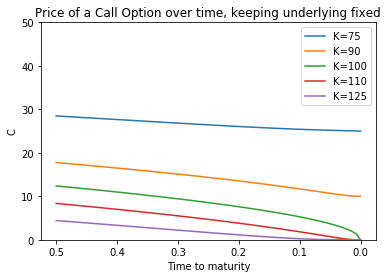

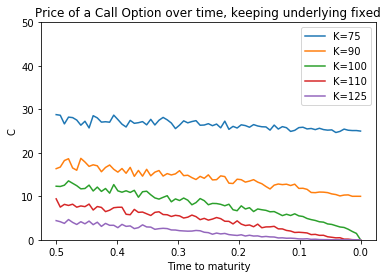

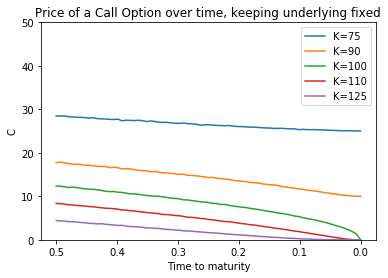

In [14]:
example(priceEuropeanCall)
example(priceEuropeanCallMC, 1000)
example(priceEuropeanCallMC, 100000)  
## Warning: this example gets really slow for increased M, 
## as it is not optimized for evaluating for multiple maturities

#### The Greeks

The European Call Option depends on multiple variables such as the strike, underlying price, volatility and interest rate. To characterize the sensitivity of the Call on these variables we look at the derivative of the Call option with respect to these variables. These sensitivities are called collectively The Greeks.

Here we look at vega, which is the sensitivity of the Call on the volatility: $\frac{\partial C}{\partial \sigma}$. In the Black-Scholes model it has an exact expression given by: $\textrm{vega} = S_0\phi(d_+)\sqrt{T}$, where this time $\phi$ is the PDF of a standard normal distribution.

In [15]:
def vegaEuropeanCall(S0,K,r,T,sigma):
    """
    Vega of a European call option
    
    INPUT:
       S0 : Initial value of the underlying asset
        K : Strike 
        r : Risk-free interest rate 
        T : Time to expiry 
    sigma : Volatility 

    OUTPUT:
     vega : Vega of the option in the Black-Scholes model  
    """
    discountedStrike = np.exp(-r * T) * K
    totalVolatility = sigma * np.sqrt(T)
    d_plus = np.log(S0 / discountedStrike) / totalVolatility + .5 * totalVolatility
    return S0 * np.sqrt(T) * norm.pdf(d_plus)


Of course, we can also determine the sensitivity numerically.

In [16]:
def numericalDerivative(f, x0, h):
    """
    Numerical estimate of the derivative of f at x0

    INPUT:
             f : Handle to the function whose derivative is being calculated
            x0 : Point at which the derivative is calculated
             h : Parameter for divided differences (1e-5 - 1e-6)

    OUTPUT:
    derivative : Value of the derivative of f at x0  
   """      
    
    if x0 == 0:
        derivative = (f(h) - f(-h))/(2 * h)
    else:
        derivative = (f(x0 * (1 + h))-f(x0 * (1 - h)))/(2 * x0 * h);
    return derivative 

Let's compare these two methods

In [17]:
def comparison():
    
    S0    = 100  # initial price
    K     = 90   # strike
    r     = 0.05 # interest rate
    T     = 2    # maturity 
    sigma = 0.4  # volatility

    ## Numerical estimate of vega
    
    # pricing function
    def fPrice(sigma):
        return priceEuropeanCall(S0,K,r,T,sigma)[0]
    # good balance between rounding and truncation errors in the numerical derivative
    h = 1e-5;

    numericalVega = numericalDerivative(fPrice,sigma,h)

    ## Vega of a European call option
    vega = vegaEuropeanCall(S0,K,r,T,sigma)
    return numericalVega, vega
print comparison()

(45.797511901035641, 45.797511899711402)


vega plays an important role in obtaining an estimate for the volatility.

#### Implied Volatility

The volatility $\sigma$ is an input into the pricing methods of the Black-Scholes formulae. One can use historical data to measure this volatiltiy, but it turns out that this leads to a poor estimate of the price of options. The main reason for this is that the Black-Scholes model does not adequately model the financial markets. 

Instead, the volatility is obtained by looking at the price of the derivatives on the market and obtain an implied volatility such that the pricing scheme reproduces the market price. We therefore need to invert the Black-Scholes formula (read from the market) to obtain the volatility. There is, however, no exact expression for the inverse of the BS formula, so we need to resort to a numerical scheme.

With the use of a pricing model such as Black-Scholes we can use the Newton-Raphson method to find an estimate for the implied volatility. The idea is simple: we have a function available for the price, which depends on the volatiltiy. We call this `fprice(sigma)`. Furthermore we have a price for the option which is taken from the market, which wel call `market_price`. We need to find a `sigma_implied` such that this `market_price` is produced by `fprice(sigma_implied)`. In other words, we are looking for a solution of `fprice(sigma) - market_price = 0`. The Newton-Raphson method is method which finds a root of a function and makes use of the derivative of the function `fprice`, which corresponds to the Greek vega. It is implemented below

In [18]:
def impliedVolatility(fPrice, fVega, price):
    """
    Implied volatility of a derivative

    INPUT:
    fPrice : Handle to the function that gives the price of the derivative
     fVega : Handle to the function that gives the vega of the derivative
     price : The price of the derivative

    OUTPUT:
     sigma : Implied volatility         
    """

    TOLABS  = 1e-6
    MAXITER = 100
    
    sigma  = 0.3          # intial estimate   
    dSigma = 10 * TOLABS  # enter loop for the first time
    nIter  = 0
    while ((nIter < MAXITER) & (abs(dSigma) > TOLABS)):
        nIter = nIter + 1
        # Newton-Raphson method
        dSigma = (fPrice(sigma)-price)/fVega(sigma)
        sigma = sigma - dSigma
    
    if (nIter == MAXITER):
        warning('Newton-Raphson not converged')
    return sigma



For example:

In [19]:
def impliedVol(price):
    S0 = 100
    K = 90
    r = 0.05
    T = 2
    def fPrice(sigma):
        return priceEuropeanCall(S0,K,r,T,sigma)[0]
    def fVega(sigma):
        return vegaEuropeanCall(S0,K,r,T,sigma)
    impliedSigma  = impliedVolatility(fPrice,fVega,price)
    impliedPrice = priceEuropeanCall(S0,K,r,T,impliedSigma)[0]  # should be equal to price
    return impliedSigma, impliedPrice, impliedPrice - price

for p in [19.8701, 26.24, 21]:
    imp_vol, imp_price, error = impliedVol(p)
    print "Implied volatility:", imp_vol
    print "Price from implied volatility", imp_price
    print "Absolute error in pricing:", np.abs(error)
    print

Implied volatility: 0.137398425806
Price from implied volatility 19.8701
Absolute error in pricing: 7.1054273576e-15

Implied volatility: 0.299996208706
Price from implied volatility 26.24
Absolute error in pricing: 3.5527136788e-15

Implied volatility: 0.172202727906
Price from implied volatility 21.0
Absolute error in pricing: 1.84741111298e-13



#### Variance Reduction

The probabilistic nature of Monte Carlo methods is the source of the relatively large variance of the price estimate. The most straightforward way to reduce the variance in the price estimate of the Monte Carlo approach is to increase the number of simulations $M$ of the MC calculation. This can be computationally expensive, since the variance is proportional to only $1/\sqrt(M)$.

Variance reduction are methods that can be used to circumvent or reduce this large increase in computational cost, while still reducing the variance of the price estimate. These reduction methods can be quite powerful, but are not universal as they depend on properties of the sampling distribution and the target price estimate.

##### Antithetic variates

The first method of variance reduction are so-called *antithetic variates*. This makes use of symmetry properties of the sampling distribution. The idea is that each drawn sample is re-used to generate another sample. The estimate of the price is then appropriately averaged over these two sample points. This technique can be applied for instance if the underlying sampling distribution is symmetric (such as a normal distribution) or is computed from a symmetric distribution (such as the lognormal distribution).

In [20]:
def priceEuropeanCallMC_antithetic(S0, K, r, T, sigma, M):
    """
    Price of a European call option in the Black-Scholes model with antithetic variates

    INPUT:
        S0 : Initial value of the underlying asset
         K : Strike 
         r : Risk-free interest rate 
         T : Time to expiry 
     sigma : Volatility 
         M : Number of simulations
 

    OUTPUT:
    price_MC : MC estimate of the price of the option in the Black-Scholes model  
    stdev_MC : MC estimate of the standard deviation            
    """
    ## Generate M samples from N(0,1)
    X = np.random.randn(M) 
    
    ## Simulate M trajectories in one step
    ST_plus  = S0*np.exp((r-0.5*sigma**2)*T + sigma*np.sqrt(T)*X);
    ST_minus = S0*np.exp((r-0.5*sigma**2)*T - sigma*np.sqrt(T)*X);
    
    ## Compute payoffs
    
    payoff_plus  = np.where(ST_plus < K, 0, ST_plus -K)
    payoff_minus = np.where(ST_minus < K, 0, ST_minus -K)
    
    # average payoff
    payoff       = 0.5*(payoff_plus+payoff_minus)
    
    ## MC estimate of the price and the error of the option
    discountFactor = np.exp(-r*T)
    price_MC = discountFactor*np.mean(payoff)
    stdev_MC = discountFactor*np.std(payoff)/np.sqrt(M)
    return price_MC, stdev_MC


We define a simple script to compare the different methods

In [23]:
def estimatePrice(method):
    S0 = 100
    K = 90
    r = 0.05
    T = 2
    sigma = 0.2
    M = 10000
    price_method, stdev_method = method(S0, K, r, T, sigma, M)
    price_exact = priceEuropeanCall(S0, K, r, T, sigma)[0]
    error = (price_method - price_exact) / price_exact  * 100
    return price_method, stdev_method, error

For instance, the MC method gives:

In [24]:
print "Price estimate, std answer, true error:", estimatePrice(priceEuropeanCallMC)

Price estimate, std answer, true error: (22.146492665393382, 0.25388983340732491, 0.51336949485221872)


As for the antithetic variaties approach:

In [25]:
print "Price estimate, std answer, true error:", estimatePrice(priceEuropeanCallMC_antithetic)

Price estimate, std answer, true error: (22.045156301373257, 0.10140307558828775, 0.053447485804893141)


#### Importance Sampling

In importance sampling we average the price by making use of a different distribution from which samples are drawn, which then typically has a lower variance. Because a different distribution is chosen, we also need to redefine the object over which is averaged.

In [28]:
def priceEuropeanCallMC_importanceSampling(S0,K,r,T,sigma,M):
    """
    Price of a European call option in the Black-Scholes model with importance sampling

    INPUT:
       S0 : Initial value of the underlying asset
        K : Strike 
        r : Risk-free interest rate 
        T : Time to expiry 
    sigma : Volatility
        M : Number of simulations
 

    OUTPUT:
     price_MC : MC estimate of the price of the option in the Black-Scholes model  
     stdev_MC : MC estimate of the standard deviation  
    """
    
    ## Generate M samples from N(0,1)
    X = np.random.randn(M)
    
    ## Simulate M trajectories in one step
    
    mu = np.log( K / S0) / T
    ST = S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * X)
    correctionFactor = norm.pdf(X + (mu - r) * np.sqrt(T) / sigma) / norm.pdf(X)
    
    ## Compute the payoffs
    payoff  = np.where(ST < K, 0, ST - K)
    correctedPayoff = payoff * correctionFactor
    
    ## MC estimate of the price and the error of the option
    discountFactor = np.exp(-r * T)
    
    price_MC = discountFactor * np.mean(correctedPayoff)
    stdev_MC = discountFactor * np.std(correctedPayoff) / np.sqrt(M)
    return price_MC, stdev_MC


In [29]:
print "Price estimate, std answer, error:", estimatePrice(priceEuropeanCallMC_importanceSampling)

Price estimate, std answer, error: (22.848712535834963, 0.65851743551080166, 3.7004423361701462)


Note that if $\log( K / S0) / T - r$ is approximately  zero, then there is no noticable gain.

#### Stratified sampling

In stratified sampling we partition the source distribution into equal-sized 'bins', i.e. each bin contributes an equal amount of probability to the overall distribution. We then sample from each bin individually, thereby reducing the overall variance.

In [33]:
def priceEuropeanCallMC_stratifiedSampling(S0,K,r,T,sigma,M,nStrata):
    """
    Price of a European call option in the Black-Scholes model with stratified sampling

    INPUT:
       S0 : Initial value of the underlying asset
        K : Strike 
        r : Risk-free interest rate 
        T : Time to expiry 
    sigma : Volatility 
        M : Number of simulations
  nStrata : Number of strata per simulation 

    OUTPUT:
     price_MC : MC estimate of the price of the option in the Black-Scholes model  
     stdev_MC : MC estimate of the standard deviation  
    """
    ## Generate M x nStrata samples from U(0,1)
    U = np.random.rand(M,nStrata)
    # delimit the strata
    strataBorders, strataSize = np.linspace(0, 1, nStrata + 1, retstep=True)
    
    # stratify U[0,1]
    V = np.tile(strataBorders[:-1], (M, 1)) + U * strataSize
    
    # stratified N(0,1)
    X = norm.ppf(V) # this is the inverse CDF, i.e. norminv in Matlab
    
    ## Simulate M trajectories in one step
    ST  = S0 * np.exp((r-0.5*sigma**2) * T + sigma * np.sqrt(T) * X)
    
    ## Compute the payoffs
    
    payoff  = np.where(ST < K, 0, ST - K)
    
    payoff  = np.mean(payoff, axis=1)  # average payoff, using one sample per strata. 
    
    ## MC estimate of the price and the error of the option
    discountFactor = np.exp(-r*T)
    
    price_MC = discountFactor * np.mean(payoff)
    stdev_MC = discountFactor * np.std(payoff) / np.sqrt(M)
    return price_MC, stdev_MC


The stratified sampling method takes an extra parameter `nStrata` to specify the number of bins.

In [34]:
def priceEuropeanCallMC_stratifiedSampling_fixed_nStrata(S0,K,r,T,sigma,M):
    nStrata = 5
    M_ = np.int(np.round(M / nStrata))
    return priceEuropeanCallMC_stratifiedSampling(S0,K,r,T,sigma,M_,nStrata)


In [35]:
print "Price estimate, std answer, error:", estimatePrice(priceEuropeanCallMC_stratifiedSampling_fixed_nStrata)

Price estimate, std answer, error: (22.029687169035459, 0.10037632617416643, -0.016760227801315902)


Finally, we compare all the different methods:

Method: priceEuropeanCall


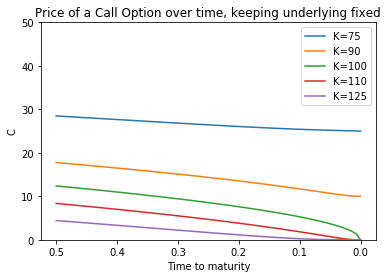

Method: priceEuropeanCallMC


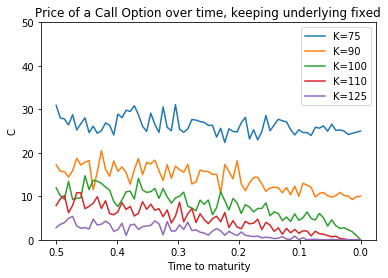

Method: priceEuropeanCallMC_antithetic


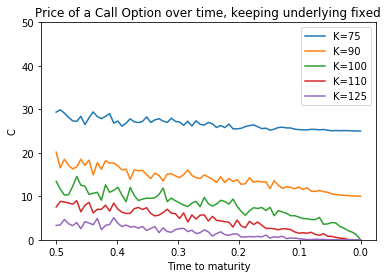

Method: priceEuropeanCallMC_importanceSampling


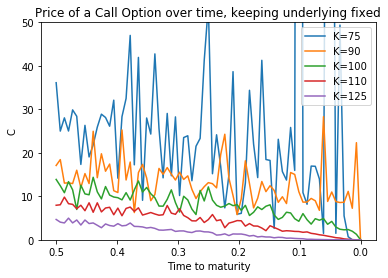

Method: priceEuropeanCallMC_stratifiedSampling_fixed_nStrata


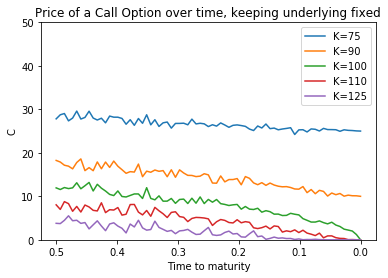

In [38]:
methodlist = [priceEuropeanCall, priceEuropeanCallMC, priceEuropeanCallMC_antithetic,
              priceEuropeanCallMC_importanceSampling, priceEuropeanCallMC_stratifiedSampling_fixed_nStrata]
M = 100
for method in methodlist:
    print "Method:", method.__name__
    example(method, 100)

The breakdown of importance_sampling for certain strikes is huge (but note that for certain K's it does actually reduce the variance).